In [ ]:
import pandas as pd

data = {
    "Weather": ["Rain", "Snow", "Clear", "Clear", "Snow",
                "Rain", "Rain", "Snow", "Clear", "Clear"],
    "Road": ["Bad", "Average", "Bad", "Good", "Good",
             "Average", "Good", "Bad", "Good", "Bad"],
    "Traffic": ["High", "Normal", "Light", "Light", "Normal",
                "Light", "Normal", "High", "High", "High"],
    "Engine": ["No", "Yes", "No", "Yes", "No",
               "No", "No", "No", "Yes", "Yes"],
    "Accident": ["Yes", "Yes", "No", "Yes", "No",
                 "No", "No", "Yes", "No", "Yes"]
}

df = pd.DataFrame(data)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

X = df[["Weather", "Road", "Traffic", "Engine"]]
y = df["Accident"]

enc = OneHotEncoder(sparse_output=False)
X_enc = enc.fit_transform(X)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
clf.fit(X_enc, y)


DecisionTreeClassifier(criterion='entropy', random_state=0)

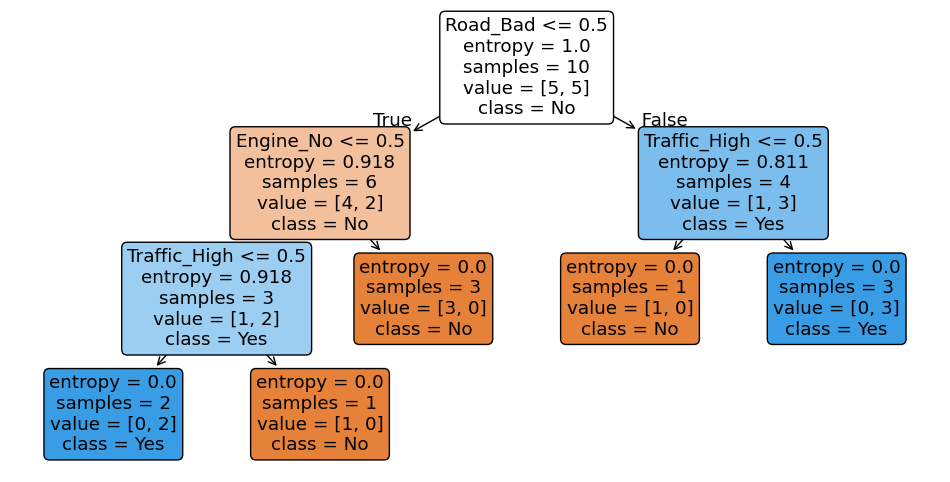

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 6))
plot_tree(
    clf,
    feature_names=enc.get_feature_names_out(["Weather", "Road", "Traffic", "Engine"]),
    class_names=clf.classes_,
    filled=True,
    rounded=True
)
plt.show()


In [ ]:
import math
from collections import Counter, defaultdict

# ---------- DATA ----------
data = [
    {"Weather": "Rain",  "Road": "Bad",    "Traffic": "High",  "Engine": "No",  "Accident": "Yes"},
    {"Weather": "Snow",  "Road": "Average","Traffic": "Normal","Engine": "Yes", "Accident": "Yes"},
    {"Weather": "Clear", "Road": "Bad",    "Traffic": "Light", "Engine": "No",  "Accident": "No"},
    {"Weather": "Clear", "Road": "Good",   "Traffic": "Light", "Engine": "Yes", "Accident": "Yes"},
    {"Weather": "Snow",  "Road": "Good",   "Traffic": "Normal","Engine": "No",  "Accident": "No"},
    {"Weather": "Rain",  "Road": "Average","Traffic": "Light", "Engine": "No",  "Accident": "No"},
    {"Weather": "Rain",  "Road": "Good",   "Traffic": "Normal","Engine": "No",  "Accident": "No"},
    {"Weather": "Snow",  "Road": "Bad",    "Traffic": "High",  "Engine": "No",  "Accident": "Yes"},
    {"Weather": "Clear", "Road": "Good",   "Traffic": "High",  "Engine": "Yes", "Accident": "No"},
    {"Weather": "Clear", "Road": "Bad",    "Traffic": "High",  "Engine": "Yes", "Accident": "Yes"},
]

attributes = ["Weather", "Road", "Traffic", "Engine"]
target = "Accident"

# ---------- STEP 1: ENTROPY ----------
def entropy(rows):
    counts = Counter(r[target] for r in rows)
    total = len(rows)
    return -sum((c/total) * math.log2(c/total) for c in counts.values())

# ---------- STEP 2: INFORMATION GAIN ----------
def info_gain(rows, attr):
    total_entropy = entropy(rows)
    total = len(rows)

    # split by attribute
    subsets = defaultdict(list)
    for r in rows:
        subsets[r[attr]].append(r)

    weighted_entropy = sum((len(sub)/total) * entropy(sub) for sub in subsets.values())
    return total_entropy - weighted_entropy

def best_attribute(rows, attrs):
    gains = {a: info_gain(rows, a) for a in attrs}
    # attribute with highest information gain
    return max(gains, key=gains.get)

# ---------- STEP 3: BUILD TREE (STEP 9) ----------
def majority_class(rows):
    return Counter(r[target] for r in rows).most_common(1)[0][0]

def build_tree(rows, attrs):
    # 1) if all in one class → leaf
    classes = {r[target] for r in rows}
    if len(classes) == 1:
        return next(iter(classes))

    # 2) if no attributes left → majority vote leaf
    if not attrs:
        return majority_class(rows)

    # 3) choose root = attribute with highest information gain
    best_attr = best_attribute(rows, attrs)

    tree = {"attribute": best_attr, "children": {}}

    # 4) split data by values of this attribute and recurse
    values = {r[best_attr] for r in rows}
    for v in values:
        subset = [r for r in rows if r[best_attr] == v]
        if not subset:
            tree["children"][v] = majority_class(rows)
        else:
            remaining_attrs = [a for a in attrs if a != best_attr]
            tree["children"][v] = build_tree(subset, remaining_attrs)

    return tree

# ---------- STEP 4: NICE PRINT ----------
def print_tree(node, indent=""):
    if isinstance(node, str):
        print(indent + "→", node)
        return
    attr = node["attribute"]
    print(indent + f"[{attr}]")
    for val, child in node["children"].items():
        print(indent + f" └── {val}:")
        print_tree(child, indent + "     ")

# ---------- RUN ----------
tree = build_tree(data, attributes)
print_tree(tree)


[Road]
 └── Bad:
     [Traffic]
      └── High:
          → Yes
      └── Light:
          → No
 └── Average:
     [Weather]
      └── Rain:
          → No
      └── Snow:
          → Yes
 └── Good:
     [Traffic]
      └── High:
          → No
      └── Light:
          → Yes
      └── Normal:
          → No
